In [ ]:
!pip install kagglehub
!pip freeze > requirements.txt

import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from pathlib import Path
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch import nn
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from transformers import ViTForImageClassification
from torch.cuda.amp import GradScaler, autocast

Device and AMP setup 

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
scaler = GradScaler() if use_cuda else None
pin_memory = use_cuda

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("iarunava/cell-images-for-detecting-malaria")

print("Path to dataset files:", path)

Path to dataset files: /Users/eliahsand/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1


In [ ]:
#!pip install torch torchvision transformers matplotlib




## Preprocessing

In [ ]:


# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image to 224x224 for ViT
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard ImageNet normalization
])

# Load the full dataset
dataset = datasets.ImageFolder(path, transform=transform)

#Define the split ratios (60% for training, 20% for validation, 20% for testing)
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset into train, validation, and test
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True, pin_memory=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=100, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, pin_memory=True)



## Model, optimizer and loss

In [ ]:
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k")
model.classifier = nn.Linear(model.config.hidden_size, 2)
model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-5)
criterion = CrossEntropyLoss()


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/anaconda3/lib/python3.12/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


## Trainingfunction

In [ ]:
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs.logits, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.logits, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return total_loss / len(loader), correct / total


/var/folders/mj/x9tzp3m55p75f9vjj4yvkq4c0000gn/T/ipykernel_6280/1507756519.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Epoch 1:   0%|          | 0/331 [00:00<?, ?batch/s]/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/mj/x9tzp3m55p75f9vjj4yvkq4c0000gn/T/ipykernel_6280/1507756519.py:50: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarni

## Early stopping class

In [ ]:
class EarlyStopping:
    def __init__(self, patience=3, delta=0.0):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_accuracy, model):
        score = val_accuracy

        if self.best_score is None or score > self.best_score + self.delta:
            self.best_score = score
            self.counter = 0
            torch.save(model.state_dict(), "best_model.pth")
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


Test Accuracy: 100.00%


## Model Training

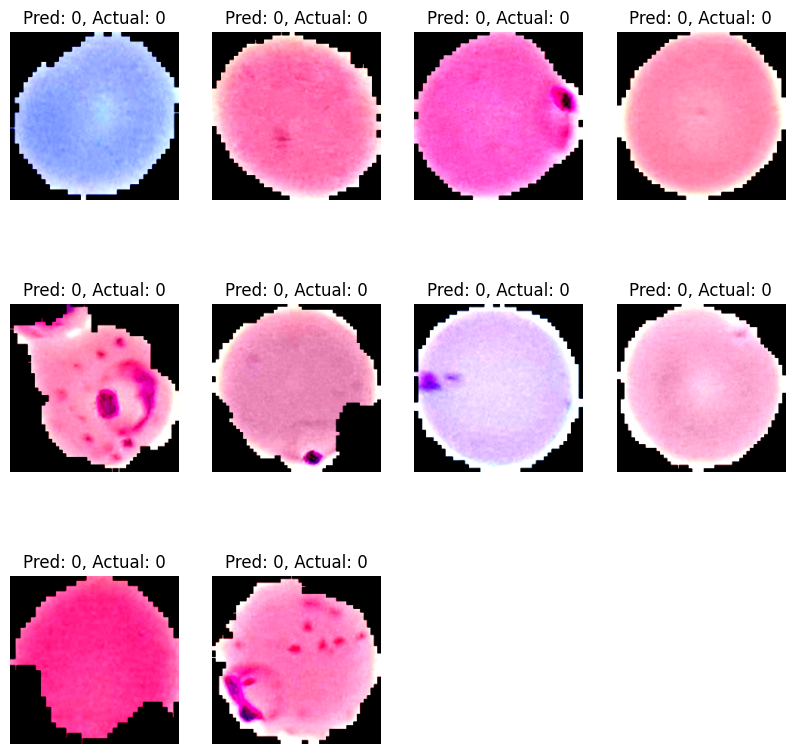

In [ ]:
train_losses, val_losses, val_accuracies = [], [], []
early_stopper = EarlyStopping(patience=3)

for epoch in range(20):  # Kan gå opp til 20, men stoppes tidlig
    model.train()
    running_loss = 0.0
    with tqdm(total=len(train_loader), desc=f"Epoch {epoch + 1}", unit='batch') as pbar:
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            if use_cuda:
                with autocast():
                    outputs = model(images)
                    loss = criterion(outputs.logits, labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(images)
                loss = criterion(outputs.logits, labels)
                loss.backward()
                optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix(loss=running_loss / len(train_loader))
            pbar.update(1)

    avg_train_loss = running_loss / len(train_loader)
    val_loss, val_acc = evaluate(model, val_loader, criterion)

    train_losses.append(avg_train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch + 1} - Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")

    early_stopper(val_acc, model)
    if early_stopper.early_stop:
        print("Early stopping triggered.")
        break


## Plotting results 

In [ ]:
epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, [v*100 for v in val_accuracies], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy per Epoch")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

## Testevaluation with best model 

In [ ]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.logits, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print(f"\n✅ Final Test Accuracy (best model): {correct / total * 100:.2f}%")